# EVA and Distribution Fitting - Colorado River case study

Imagine you are an hydraulic engineer and you are required to do some analysis on a certain river because of an intervention that needs to be done for drinking water supply to a close village.

Specifically, you are asked to understand how the water discharge $Q$ and the suspended sediment discharge $Q_{ss}$ change in time, how the extreme values of both variables behave and to fit a distribution for these extremes in order to be able to make future predictions. After that, you should also study whether there is a correlation between the two variables or not and, in case there is, how strong it is and on which time scale (daily, weekly, etc.).

As mentioned, the data we are interested in are the water discharge and the suspended sediment discharge and the river we deal with is the Colorado River in a location near Cisco, in Utah. 

Aims of the case study are:
1) import and clear the data;
2) visualize the data;
4) Gumbel and GEV distribution fitting, both using analytic expressions and the _scipy_ functions;
5) comparison (mainly in terms of accuracy and future predictions);
6) correlation analysis (with different time scales).

This case study is based on real data collected from a gauge located along the Colorado River, in the USA. Data come from the USGS "Surface Water - Historical observations" database, for more info see https://waterdata.usgs.gov/nwis.  
Gauge site number: USGS 09180500 COLORADO RIVER NEAR CISCO, UT.

### 1. import and clear the data

Let's start by importing the libraries we will use in this case study.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci
import pathlib
import datetime

%matplotlib inline

Before importing the data we have to add the directory of the folder where the file is located.

*Remember to change the directory that is actually in the code with the directory of your computer to make it work!*


In [38]:
# Create path to the data folder

data_dir = pathlib.Path(r'C:\Users\anton\OneDrive\Desktop\MUDE_23_24\book-1\book\sandbox\Assignment1_AMagherini').expanduser()
site = list(sorted(data_dir.glob('Colorado river.txt')))
site[0]

WindowsPath('C:/Users/anton/OneDrive/Desktop/MUDE_23_24/book-1/book/sandbox/Assignment1_AMagherini/Colorado river.txt')

Unfortunately, if you try to download only water and suspended sediment discharge data, as you can see in the "Colorado river.txt" file, the USGS website also provides many more information we don't really need (at least we don't need them for this analysis).

Therefore, we firstly delete all those rows that don't contain any data (i.e, the first 49 rows) and the first two columns which contain the agency name (_USGS)_ and the site number. 

In [39]:
df = pd.read_csv(site[0], skiprows = 49, header = 0,  sep='\t', engine='python').drop(['agency_cd', 'site_no'], axis = 1).drop([0], axis = 0)

Moreover, the *.txt* file contains many other data (i.e., many other columns) that are not necessary for our analysis.

For instance, from column 12 onwards data such as water temperature $T$, $pH$ and other variables are included. But we don't need all those data, so we can get rid of them.  

_Coding question_

Why is the line *df.drop(df.columns[1:3], axis = 1, inplace = True)* repeated twice?

*Hint: try to split each line into four different code spaces and for each of them display the resulting* df.

In [40]:
# Drop columns that will not be used

df.drop(df.columns[12:], axis =1, inplace = True)
df.drop(df.columns[1:3], axis = 1, inplace = True)
df.drop(df.columns[1:3], axis = 1, inplace = True)
df.drop(df.columns[2:7], axis = 1, inplace = True)
df

,datetime,142741_00060_00003,142745_80155_00003
1,1949-05-01,24200,144000
2,1949-05-02,21200,51500
3,1949-05-03,19700,26600
4,1949-05-04,23300,201000
5,1949-05-05,24600,547000
...,...,...,...
27040,2023-05-12,30300,NaN
27041,2023-05-13,30600,NaN
27042,2023-05-14,32300,NaN
27043,2023-05-15,33700,NaN


Remember: the file contains daily mean data.

Now let's rename the columns. 

In [41]:
# Rename columns for better reference

df.rename(columns = {'datetime': 'Date',
                     '142741_00060_00003': r'Discharge $(m^3 s^{-1})$',
                     '142745_80155_00003': r'Suspended sediment discharge $(ton$ $day^{-1})$'
                     }, inplace = True)

# store column names making it easier to call
col = df.columns.values

Unfortunately, the unit of measurements of the data are not in SI units but in US units (*damn Americans!*), so we need to convert them.

We also change the data type of the first column (day of record) into "date type", which will facilitate our analysis later on.   

In [42]:
# change dtype of columns to manipulate data more easily and convert into SI units

df[col[1]] = df[col[1]].astype('int') * 0.0283168
df[col[2]] = df[col[2]].astype('float') * 0.91
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
1,1949-05-01,685.26656,131040.0
2,1949-05-02,600.31616,46865.0
3,1949-05-03,557.84096,24206.0
4,1949-05-04,659.78144,182910.0
5,1949-05-05,696.59328,497770.0
...,...,...,...
27040,2023-05-12,857.99904,NaN
27041,2023-05-13,866.49408,NaN
27042,2023-05-14,914.63264,NaN
27043,2023-05-15,954.27616,NaN


As we can see, water discharge data are recorded starting from 1949 until 2023, while suspended sediment discharge data stop in 1984 (remember this, it will turn out to be relevant for later analysis). 

### 2. visualize the data

Now that the data have been cleared and the dataframe is ready for our analysis, we can plot the data.


_Question_

What are the main features that emerge from the plots? What can you say about the peaks of both time series?

C:\Users\anton\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


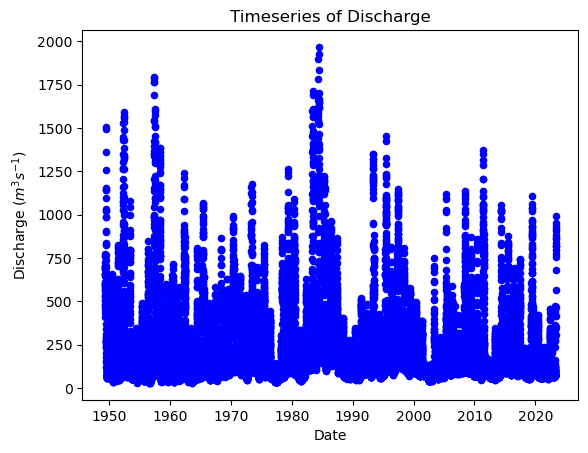

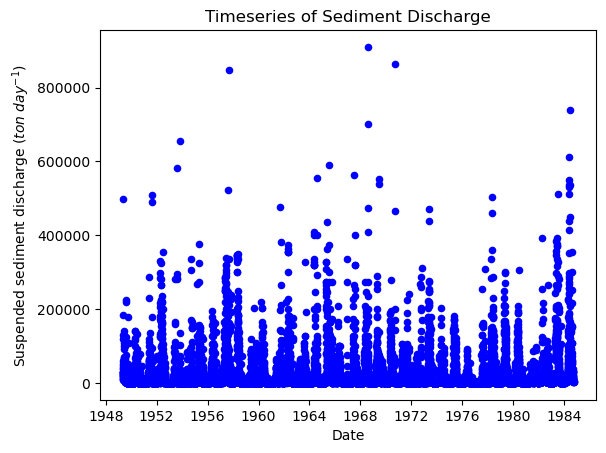

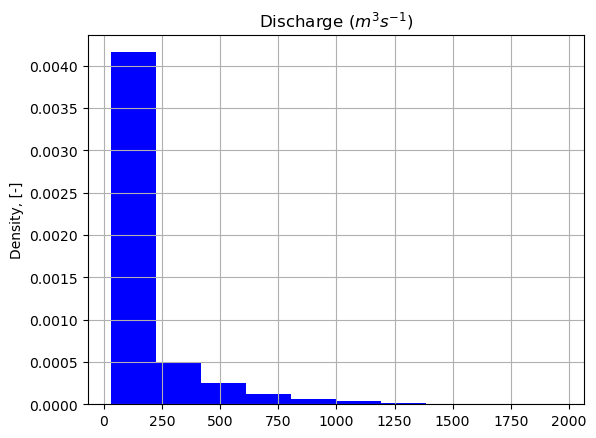

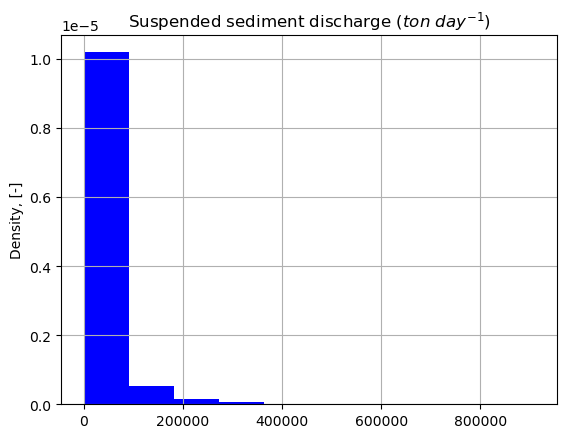

In [43]:
# plots to understand the data 

df.plot(kind = 'scatter', x = 'Date', y = col[1], title = 'Timeseries of Discharge', color='b');    
plt.show()

df.plot(kind = 'scatter', x = 'Date', y = col[2], title = 'Timeseries of Sediment Discharge', color='b');    
plt.show()

df.hist(col[1], density = True, color='b')
plt.ylabel('Density, [-]')
plt.show()

df.hist(col[2], density = True, color='b')
plt.ylabel('Density, [-]')
plt.show()

Now it's time to start the EVA (Extreme Value Analysis). For this reason, we have to select the extreme data that are present in our file. 

We decide to use the block maxima approach: for each year we sample the maximum value recorded and store it in a new dataframe.

Let's create the function *yearly_maxima*.

In [44]:
def yearly_maxima(data, column):
    '''
    Function that samples the yearly maximum of parameters in data frame for the requested column index
    '''
    col = data.columns.values
    idx_max = data.groupby(pd.DatetimeIndex(data[col[0]]).year)[col[column]].idxmax()
    max_list = data.loc[idx_max]
    return max_list

Now we apply the function only on water discharge and then we plot the result.

Note: in the new dataframe we also include the suspended sediment discharge record related to the sampled extreme water discharge. 

In [45]:
yearly_maxima_discharge = yearly_maxima(df, 1) # maxima of discharge, accompanying values of sediment
yearly_maxima_discharge

,Date,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
52,1949-06-21,1506.45376,91910.0
400,1950-06-04,659.78144,133770.0
760,1951-05-30,824.01888,285740.0
1137,1952-06-10,1594.23584,182000.0
1507,1953-06-15,1076.03840,100100.0
...,...,...,...
25608,2019-06-10,1107.18688,NaN
25966,2020-06-02,421.92032,NaN
26336,2021-06-07,235.02944,NaN
26683,2022-05-20,455.90048,NaN


And now plot again the discharge time series with the yearly extremes highlighted. 

C:\Users\anton\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


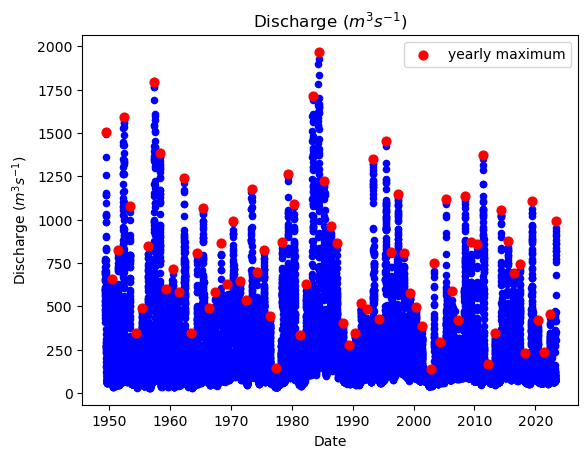

In [46]:
# Plot flow discharge historic data with maxima

df.plot(kind = 'scatter', x= 'Date', y = col[1], color='b')
plt.scatter(yearly_maxima_discharge['Date'], yearly_maxima_discharge[col[1]], 40, 'r', label='yearly maximum')
plt.title(col[1])
plt.legend(loc='best');

The same procedure will be repeated later on for the suspended sediment discharge, but for the moment we are not interested in it.

### 3. distribution fitting

Once the extermes are sampled, we can proceed with the fitting of a distribution which can be used for forecasting future and in general unrecorded (extreme) values.

First, let's show the main statistics of the initial (and complete) dataframe and later only of the one containing the water discharge extremes (and the related suspended sediment discharge).

In [47]:
df.describe()

,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
count,27044.000000,12936.000000
mean,183.631432,22731.557587
std,201.007337,55728.286699
min,28.316800,12.740000
25%,82.118720,705.022500
50%,111.851360,2275.000000
75%,178.679008,15470.000000
max,1968.017600,910000.000000


In [48]:
#annual maxima statistics of flow discharge and related sediment discharge

yearly_maxima_discharge.describe()

,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
count,75.000000,36.000000
mean,788.815434,134329.144444
std,414.193874,79077.593308
min,135.637472,7935.200000
25%,470.058880,81649.750000
50%,741.900160,130585.000000
75%,1071.790880,166302.500000
max,1968.017600,328510.000000


It's clear that the dataframe containing the yearly extremes has higher values for all percentiles, and the same holds for the related suspended sediment values.
However, we can already notice something that at first impression seems weird: the max of the suspended sediment discharge extremes is not the same as the max of the whole record of suspended sediment discharge.

_Question_

What could it mean in terms of the relation $Q_{max}$-$Q_{ss,max}$? 
\
Is it an outlier or could it be the sign of some unexpected trend that we need to look further into deep later on?

At this point we need to fit the empirical cumulative distribution (ECDF), therefore we create the next function. 

In [81]:
def calculate_ecdf(extreme_value_data, column):
    """
    Fit an emperical cumulative distribution function to known values for a given column index 
    """
    col = extreme_value_data.columns.values          
    
    # Sort the dataframe from high to low values based on the column of the extreme value     
    sorted_data = extreme_value_data.sort_values(by = col[column], ascending=True)

    # removing the first two entries gives a better fit for genextreme
    sorted_data = sorted_data[2:] 

    # Reset the index, because in this specific case we have to work with an index starting from 1 not 0 
    sorted_data.reset_index(drop=True, inplace=True)     
        
    sorted_data.index = sorted_data.index + 1      
    
    # Calculating the total length of the dataframe     
    N = len(sorted_data[col[column]])       
    
    # Filling this new column with the F(x) score     
    sorted_data['F_x'] = sorted_data.index / (N + 1)     
    
    ecdf = sorted_data[['F_x', col[column]]]   
         
    return ecdf 

_Exercise_

Try commenting the line *sorted_data = sorted_data[2:]* inside the _calculate_ecdf_ function and run again the code until the Gumbel fit. What happens to the fitting line?

Then change the same line into *sorted_data = sorted_data[1:]* and follow the same procedure. 
\
What can you see? Do you have any idea why that happens? 

Eventually remember to set again the initial line and run again the code.

In [82]:
ecdf_blockmax = calculate_ecdf(yearly_maxima_discharge, 1)
ecdf_blockmax.head()

,F_x,Discharge $(m^3 s^{-1})$
1,0.013514,165.936448
2,0.027027,231.348256
3,0.040541,235.029440
4,0.054054,273.823456
5,0.067568,294.494720


In [83]:
# this function is just used to plot the results, you don't need to spend time on understanding it

def plot_density_functions(empirical_df, x, pdf, cdf, CI_1, CI_2, quantiles, method, curve):
    '''
    Plots pdf, cdf, return period and QQ plot for a given function. Confidence intervals are included in 
    return period graph.
    '''
    # pdf
    empirical_df.hist(col[1], density = True, label = 'Empirical Histogram', color='b')
    plt.title('PDF from' + method + 'using' + curve) 
    plt.plot(x, pdf, 'r', label = 'Fitted' + curve)
    plt.ylabel('f(x)') 
    plt.xlabel(col[1]) 
    plt.grid() 
    plt.legend()
    if curve == ' genextreme': plt.yscale('log')
    plt.show()
    # cdf
    plt.scatter(empirical_df[col[1]], empirical_df['F_x'], 40, 'k', label = 'Empirical cdf') 
    plt.title('CDF from' + method + 'using' + curve) 
    plt.plot(empirical_df[col[1]], cdf, 'r', label = 'Fitted' + curve)
    plt.ylabel('F(x)') 
    plt.xlabel(col[1]) 
    plt.grid() 
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    # inv cdf
    plt.scatter(1 / (1 - empirical_df['F_x']), empirical_df[col[1]], 40, 'k',
                label = 'Empirical inverse cdf') 
    plt.title('Return Period from' + method + 'using' + curve) 
    plt.plot(1 / (1 - cdf), empirical_df[col[1]], 'r', label = 'Fitted' + curve)
    plt.plot(1 / (1 - CI_1), empirical_df[col[1]], 'b', label = 'CI' + curve) 
    plt.plot(1 / (1 - CI_2), empirical_df[col[1]], 'b') 
    plt.xlabel('Return Period [years]') 
    plt.ylabel(col[1]) 
    plt.xscale('log')
    plt.grid() 
    plt.legend()
    plt.show()
    # QQ Plot
    empirical_quantiles = empirical_df[col[1]]

    plt.figure(figsize = (6, 6))
    plt.scatter(empirical_quantiles, quantiles, 40, 'k', label = curve)
    linear = np.array([250, 2000])
    plt.plot(linear, linear, label = 'Perfect fit')
    plt.title('QQ-plot for' + curve)
    plt.ylabel(r'Theoretical quantiles (Discharge [$m^3$ $s^{-1}$])')
    plt.xlabel(r'Empirical quantiles (Discharge [$m^3$ $s^{-1}$])')
    plt.grid()
    plt.legend()
    plt.show()

To begin with, you need to compute the parameters of the GEV fit. These parameters depend on the data you have to work with and therefore vary depending on them (they are not constant!).

*Include the confidence intervals?*

##### GEV fit

We make use of the _scipy.stats.genextreme_ library for the distribution fitting. For more info on this library see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html.

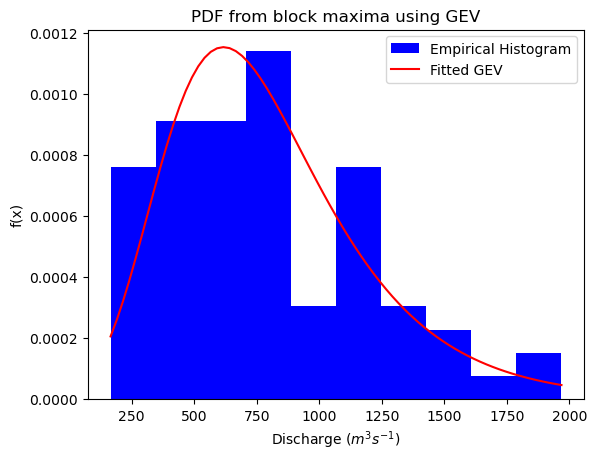

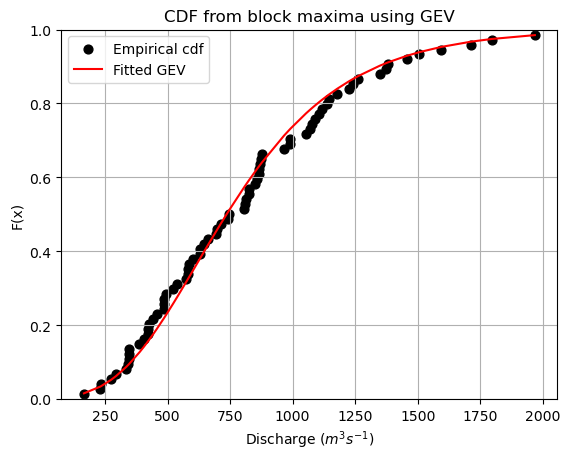

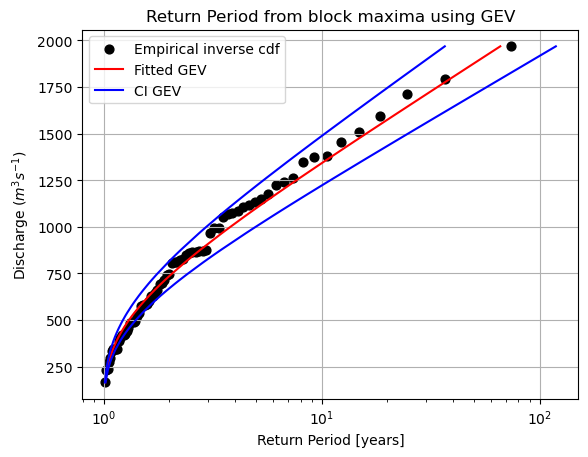

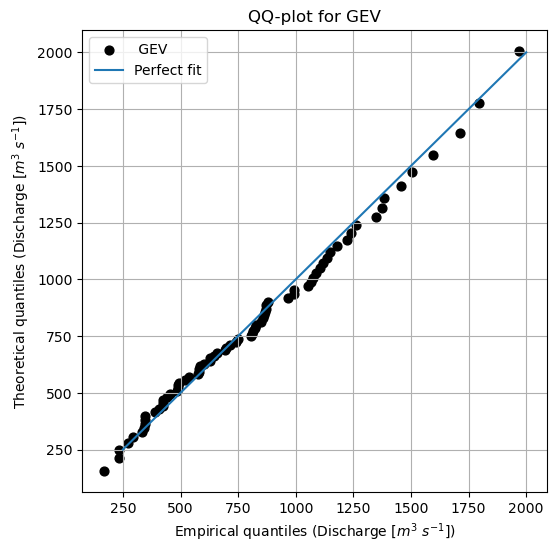

In [84]:
# compute parameters and corresponding pdf, cdf, CI, quantiles for GEV and plot them

GEV_param_blockmax = sci.genextreme.fit(ecdf_blockmax[col[1]], method = 'mle')

spacing = np.linspace(min(ecdf_blockmax[col[1]]), max(ecdf_blockmax[col[1]]), len(ecdf_blockmax[col[1]]))

GEV_pdf = sci.genextreme.pdf(spacing, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf = sci.genextreme.cdf(ecdf_blockmax[col[1]], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_quantiles = sci.genextreme.ppf(ecdf_blockmax['F_x'], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])


#include CI or not?
sigma = 0.05 * ecdf_blockmax[col[1]]
k95 = sci.norm.ppf(1-0.05/2)
k95_sig = k95*sigma

GEV_cdf_ci1 = sci.genextreme.cdf(ecdf_blockmax[col[1]] + k95_sig, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf_ci2 = sci.genextreme.cdf(ecdf_blockmax[col[1]] - k95_sig, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
#include CI or not?

plot_density_functions(ecdf_blockmax, spacing, GEV_pdf, GEV_cdf, GEV_cdf_ci1, GEV_cdf_ci2,  GEV_quantiles, ' block maxima ', ' GEV')

_Question_

What can you say about the quality of the fit? Is it acceptable for the whole dataset? Is it better for certain values and not as good for some others?

##### Gumbel fit

Again, we make use of the _scipy.stats_gumbel_r_ library. For more info see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_r.html.

In [53]:
# compute parameters and corresponding pdf, cdf, CI, quantiles for Gumbel and plot them

gamma = 0.5772156649   #Euler constant

def alpha_beta(data):   
    '''
    Function that computes the Gumbel parameters alpha and beta'''
    beta = (np.sqrt(6) * np.std(data)) / (np.pi)
    alpha = np.mean(data) - gamma * beta
    return alpha, beta

def gumbel_pdf(data, x):
    '''
    Function that computes the Gumbel PDF

    Input: data = data
           x    = spacing of output
    
    Output: pdf = Gumbel PDF
    '''
    alpha, beta = alpha_beta(data)

    pdf = sci.gumbel_r.pdf(x, loc = alpha, scale = beta)
    return pdf

def gumbel_cdf(data, x):
    '''
    Function that computes the Gumbel CDF

    Input: data = data
           x    = spacing of output
    
    Output: pdf = Gumbel CDF
    '''
    alpha, beta = alpha_beta(data)

    cdf = sci.gumbel_r.cdf(x, loc = alpha, scale = beta)
    return cdf

def gumbel_ppf(data, probability):
    '''
    Function that computes the Gumbel CDF

    Input: data = data
           probability = emperical cdf of data
           x    = spacing of output
    
    Output: pdf = Gumbel CDF
    '''
    alpha, beta = alpha_beta(data)

    ppf = sci.gumbel_r.ppf(probability, loc = alpha, scale = beta)
    return ppf

gum_pdf = gumbel_pdf(ecdf_blockmax[col[1]], spacing)
gum_cdf = gumbel_cdf(ecdf_blockmax[col[1]], ecdf_blockmax[col[1]])
gum_ppf = gumbel_ppf(ecdf_blockmax[col[1]], ecdf_blockmax['F_x'])

gum_cdf_ci1 = gumbel_cdf(ecdf_blockmax[col[1]] + k95_sig, ecdf_blockmax[col[1]])
gum_cdf_ci2 = gumbel_cdf(ecdf_blockmax[col[1]] - k95_sig, ecdf_blockmax[col[1]])

_Exercise_

Create a function yourself to compute the Gumbel PDF, CDF, and PPF without using the _scipy_ library.

_Hint: you already have a function for computing the Gumbel parameters $\alpha$ and $\beta$._

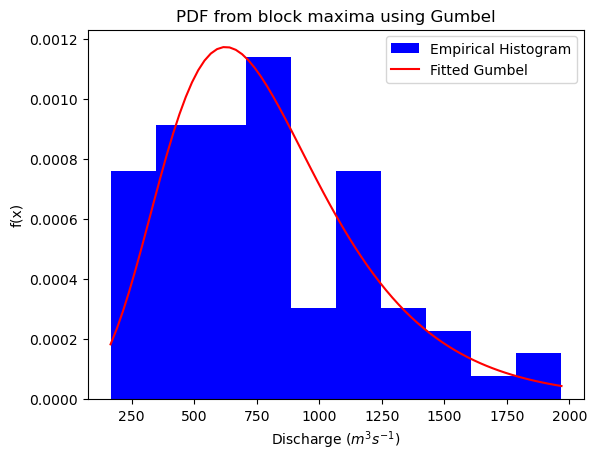

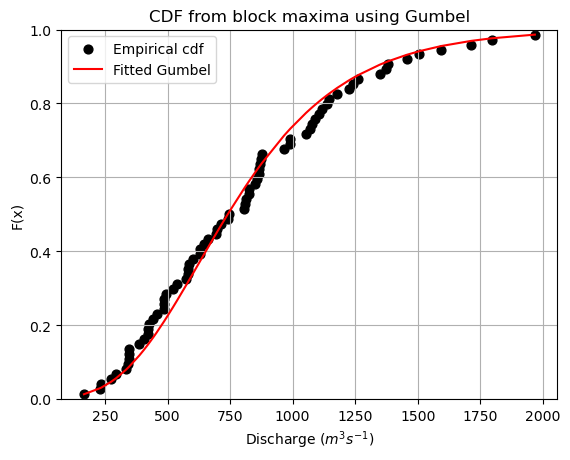

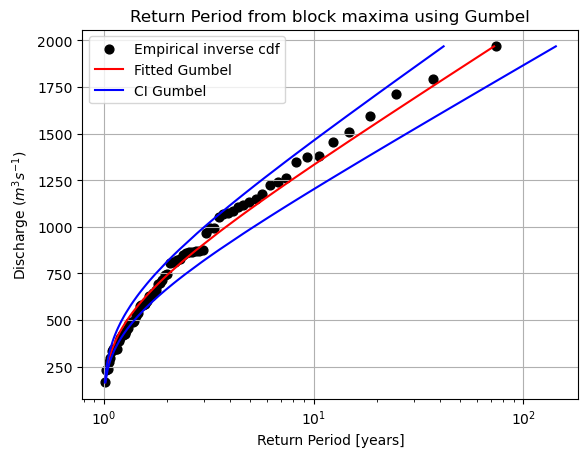

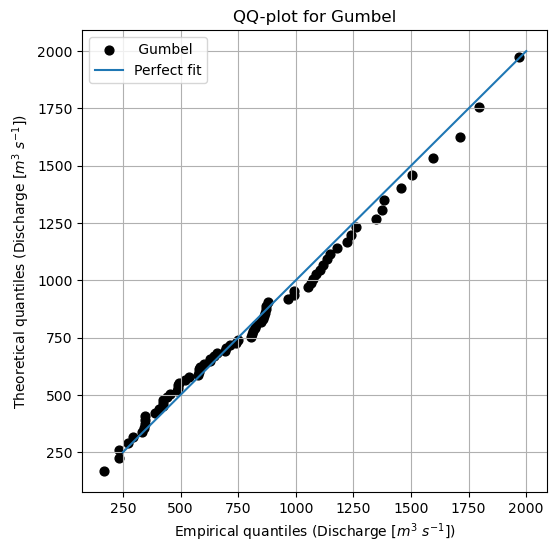

In [54]:
plot_density_functions(ecdf_blockmax, spacing, gum_pdf, gum_cdf, gum_cdf_ci1, gum_cdf_ci2, gum_ppf, ' block maxima ', ' Gumbel')

_Question_

What can you say about the quality of the fit? Is it acceptable for the whole dataset? Is it better for certain values and not as good for some others?

### 4. comparison

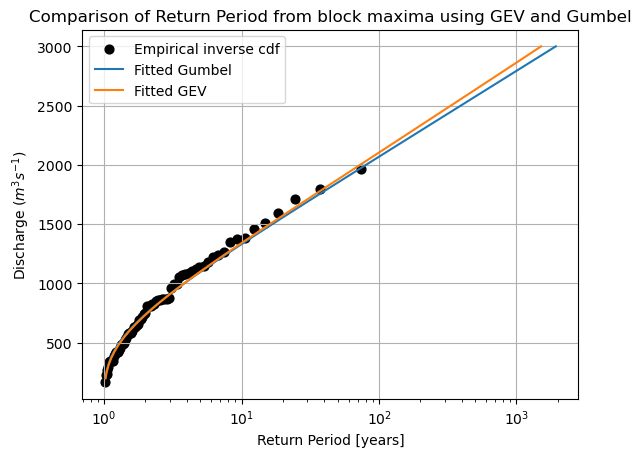

In [55]:
# you don't need to spend much time on this code, this is just for visualizing and compare the two fits

ext_spacing = np.linspace(200, 3000)
gum_cdf_ext = gumbel_cdf(ecdf_blockmax[col[1]], ext_spacing)
GEV_cdf_ext = sci.genextreme.cdf(ext_spacing, GEV_param_blockmax[0],
                             GEV_param_blockmax[1], GEV_param_blockmax[2])

plt.scatter(1 / (1 - ecdf_blockmax['F_x']), ecdf_blockmax[col[1]], 40, 'k',
            label = 'Empirical inverse cdf')
plt.title('Comparison of Return Period from block maxima using GEV and Gumbel') 
plt.plot(1 / (1 - gum_cdf_ext), ext_spacing, label = 'Fitted Gumbel')
plt.plot(1 / (1 - GEV_cdf_ext), ext_spacing, label = 'Fitted GEV')
plt.xlabel('Return Period [years]') 
plt.ylabel(col[1]) 
plt.xscale('log')
plt.grid() 
plt.legend()
plt.show()

_Question_

How do the two distributions fit the empirical data? Which one looks better? Which one does lead to a more conservative result, that means to a larger safety?

### 5. correlation analysis

As said before (see _Section 1_), suspended sediment discharge records stop in 1984. Therefore, if we want to study a correlation between the two variables, we can only work with "comparable" datasets, which means that we cannot work with water discharge data recorded after 1984.  

In [56]:
# drop all rows with nan values to make the columns the same length 

df = df.iloc[:len(df[col[2]].dropna())]
df

,Date,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
1,1949-05-01,685.266560,131040.0
2,1949-05-02,600.316160,46865.0
3,1949-05-03,557.840960,24206.0
4,1949-05-04,659.781440,182910.0
5,1949-05-05,696.593280,497770.0
...,...,...,...
12932,1984-09-25,188.306720,3658.2
12933,1984-09-26,186.890880,2156.7
12934,1984-09-27,188.589888,4013.1
12935,1984-09-28,187.740384,3649.1


Now we can apply again the block maxima recipe for both variables, respectively.

In [57]:
yearly_maxima_dis = yearly_maxima(df, 1)  # maxima of discharge, accompanying values sediment
yearly_maxima_dis

,Date,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
52,1949-06-21,1506.453760,91910.0
400,1950-06-04,659.781440,133770.0
760,1951-05-30,824.018880,285740.0
1137,1952-06-10,1594.235840,182000.0
1507,1953-06-15,1076.038400,100100.0
1849,1954-05-23,345.464960,82446.0
2232,1955-06-10,487.048960,141960.0
2592,1956-06-04,849.504000,127400.0
2963,1957-06-10,1795.285120,253890.0
3317,1958-05-30,1381.859840,120120.0


In [58]:
yearly_maxima_sed = yearly_maxima(df, 2)  # maxima of sediment, accompanying values of discharge
yearly_maxima_sed

,Date,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
5,1949-05-05,696.593280,497770.0
345,1950-04-10,294.494720,141050.0
851,1951-08-29,153.193888,508690.0
1164,1952-07-07,498.375680,354900.0
1638,1953-10-24,270.142272,655200.0
1973,1954-09-24,120.912736,336700.0
2200,1955-05-09,464.395520,376740.0
2565,1956-05-08,481.385600,193830.0
3045,1957-08-31,453.068800,846300.0
3296,1958-05-09,959.939520,348530.0


_Question_

At a first glance we can already see that the two new dataframes are not the same. What does it mean?

We have already highlighted the maxima of the water discharge, so now we plot the maxima of the suspended sediment discharge. 

C:\Users\anton\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


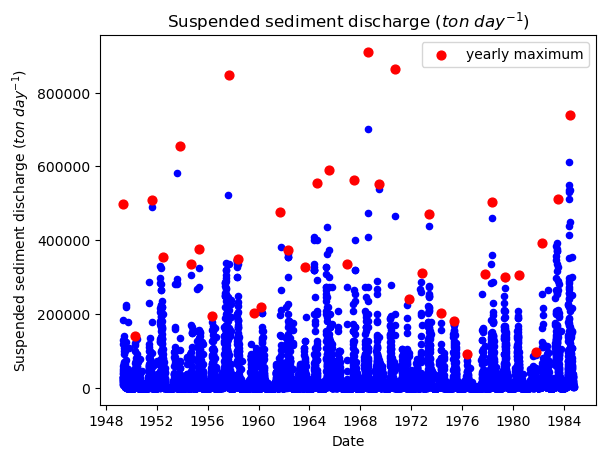

In [59]:
# Plot suspended sediment discharge historic data with maxima
df.plot(kind = 'scatter', x= 'Date', y = col[2], color='b')
plt.scatter(yearly_maxima_sed['Date'], yearly_maxima_sed[col[2]], 40, 'r', label='yearly maximum')
plt.title(col[2])
plt.legend(loc='best');

_Question_

Do you notice any relevant difference among this plot and the water discharge maxima previously plotted? What can we say about the variability of the maxima? What about the variability between peak values and base values?

_Hint: how many peak values do you see per year in this plot and in the water discharge maxima plot?_ 

Now let's look at the main statistics of both extreme dataframes.

In [60]:
#annual maxima statistics of water discharge and related suspended sediment discharge 

yearly_maxima_dis.describe()

,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
count,36.000000,36.000000
mean,882.359354,134329.144444
std,445.956430,79077.593308
min,140.734496,7935.200000
25%,580.494400,81649.750000
50%,816.939680,130585.000000
75%,1110.018560,166302.500000
max,1968.017600,328510.000000


In [61]:
#annual maxima statistics of suspended sediment discharge and related water discharge 

## this results are different from the previous ones!

yearly_maxima_sed.describe()

,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
count,36.000000,36.000000
mean,491.296480,413595.000000
std,374.496762,210223.393513
min,95.710784,92820.000000
25%,218.039360,284602.500000
50%,399.266880,364000.000000
75%,680.311120,521885.000000
max,1642.374400,910000.000000


_Question_

Do you notice any difference among the statistics of the two dataframes?

_Hint: look at the min and max values of water discharge and the related suspended sediment discharge_

Now we can move on and study the correlation among the two variables.

First, we create a function that computes the covariance $Cov$ of the two variables and the Pearson coefficient $\rho$.

In [62]:
def calculate_covariance(X1, X2):
    '''
    Computes covariance for 2 given variables
    '''
    mean_x1 = np.mean(X1)
    mean_x2 = np.mean(X2)
    diff_x1 = [item-mean_x1 for item in X1]
    diff_x2 = [item-mean_x2 for item in X2]
    product = [a*b for a,b in zip(diff_x1,diff_x2)]
    covariance = np.mean(product)
    return covariance

def pearson_correlation(X1, X2):
    '''
    Computes correlation coefficent for 2 given variables
    '''
    covariance = calculate_covariance(X1, X2)
    correl_coeff = covariance/(np.std(X1)*np.std(X2))
    return correl_coeff

C:\Users\anton\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


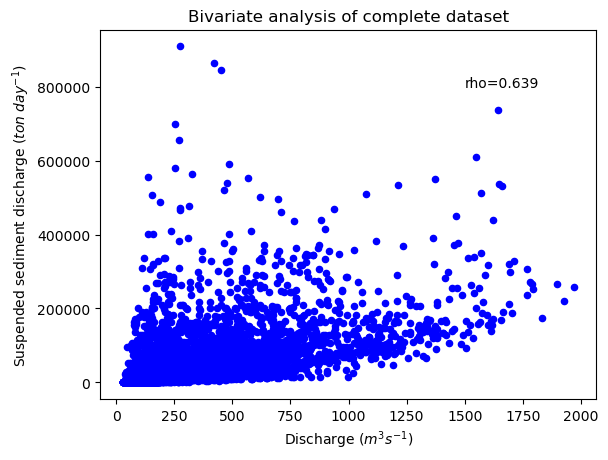

In [63]:
df.plot(kind = 'scatter', x = col[1], y = col[2], title = 'Bivariate analysis of complete dataset', c = 'b');
correl_coeff = pearson_correlation(df[col[1]], df[col[2]])
plt.text(1500, 800000, f'rho={correl_coeff:.3f}')   
plt.show()

We can see that there is a sort of positive correlation between water and suspended sediment discharge, however this is not really strong ($\rho=0.639$).

We can notice that the max value of suspended sediment discharge does not occur together with the max of the water discharge and, at the same time, the max of the water discharge is related to a pretty low value of the suspended sediment discharge.

This result can be a bit confusing. In fact, one could expect that the largest values of suspended sediment discharge should occur together with the largest value of the water discharge, that means that $\rho \simeq 1$.

What can we do for improving our analysis? Is this the only correlation we can think of or can there be another one that could possibly show more insights and give us more information on the trends of the two variables?

What happens, for instance, if we look for a correlation by using the weekly maxima values of both water discharge and suspended sediment discharge instead of the yearly maxima? What if we use the weekly mean instead of the weekly maxima?

Let's see what happens.

First, we create a function for plotting the results.

In [64]:
def bivariate_plot(df, type, period):
    '''
    Plots the bivariate analysis depending on which procedure was used (mean, max) and the period (week, year)
    Color map makes it easy to distinguish temporal trend (if present)
    Correlation Coefficient is added as a text to show correlation
    '''
    df.plot(kind = 'scatter', x = col[1], y = col[2], c = period, cmap = 'jet', title = 'Bivariate Analysis using the ' + type + ' over each ' + period);
    rho = pearson_correlation(df[col[1]], df[col[2]])
    plt.text(500, 80000, f'rho={rho:.3f}');
    plt.show()

Let's start with the yearly maxima of both water discharge and suspended sediment discharge.
\
Remember: they don't necessarily occur together as we have seen before.

In [65]:
yearly_maxima = pd.DataFrame({col[1]: yearly_maxima_dis[col[1]].values, col[2]: yearly_maxima_sed[col[2]].values, 'year': np.arange(1949, 1985)})
yearly_maxima.head()

,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$,year
0,1506.45376,497770.0,1949
1,659.78144,141050.0,1950
2,824.01888,508690.0,1951
3,1594.23584,354900.0,1952
4,1076.03840,655200.0,1953


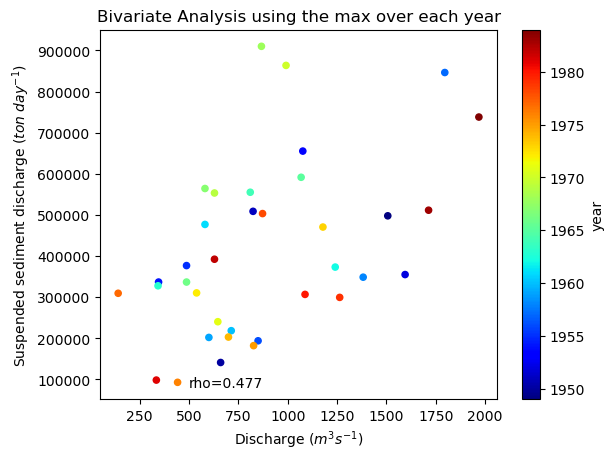

In [66]:
bivariate_plot(yearly_maxima, 'max', 'year')

As somehow expected, the value of $\rho$ is quite low (even than before), so we should try to find some other trend.

We can try to work with weekly maxima and then with weekly mean. We create two functions that compute the required values and then we repeat the same procedure as before. 

In [67]:
def weekly_max(data, column):
    '''
    Function that calculates the weekly maximum for a data frame for a given column index
    '''
    col = data.columns.values
    id_max = data.groupby(pd.DatetimeIndex(data[col[0]]).week)[col[column]].idxmax()
    max_list = data.loc[id_max]
    return max_list

In [68]:
def weekly_mean(data, column):
    '''
    Function that calculates the weekly mean for a data frame for a given column index
    '''
    col = data.columns.values
    list_mean = data.groupby(pd.DatetimeIndex(data[col[0]]).week)[col[column]].mean()
    return list_mean

Remember: you need to calculate the weekly maxima (mean) of both water discharge and suspended sediment discharge!

In [69]:
dis_week_max = weekly_max(df, 1)
sed_week_max = weekly_max(df, 2)
week_max = pd.DataFrame({col[1]: dis_week_max[col[1]].values, col[2]: sed_week_max[col[2]].values, 'week': np.arange(1, 54)})
week_max.head()

C:\Users\anton\AppData\Local\Temp\ipykernel_29372\599401678.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  id_max = data.groupby(pd.DatetimeIndex(data[col[0]]).week)[col[column]].idxmax()


,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$,week
0,172.732480,72800.0,1
1,184.625536,9100.0,2
2,171.316640,28210.0,3
3,164.237440,18655.0,4
4,185.475040,45864.0,5


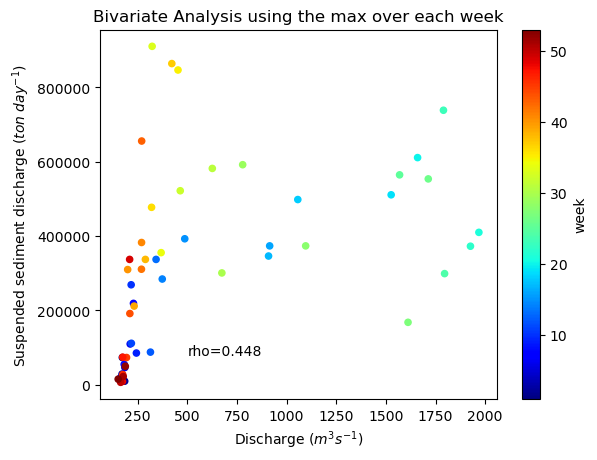

In [70]:
bivariate_plot(week_max, 'max', 'week')

Again, this result does not seem to give any useful information about the correlation between the two variables ($\rho$ is still quite low).

In [71]:
dis_week_mean = weekly_mean(df, 1)
sed_week_mean = weekly_mean(df, 2)
week_mean = pd.DataFrame({col[1]: dis_week_mean.values, col[2]: sed_week_mean, 'week': np.arange(1, 54)})
week_mean.head()

C:\Users\anton\AppData\Local\Temp\ipykernel_29372\94637166.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  list_mean = data.groupby(pd.DatetimeIndex(data[col[0]]).week)[col[column]].mean()


,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$,week
Date,,,
1,93.298655,1837.895429,1
2,95.538572,1340.626857,2
3,96.010133,1621.724000,3
4,94.798867,1627.176571,4
5,94.797712,2108.065143,5


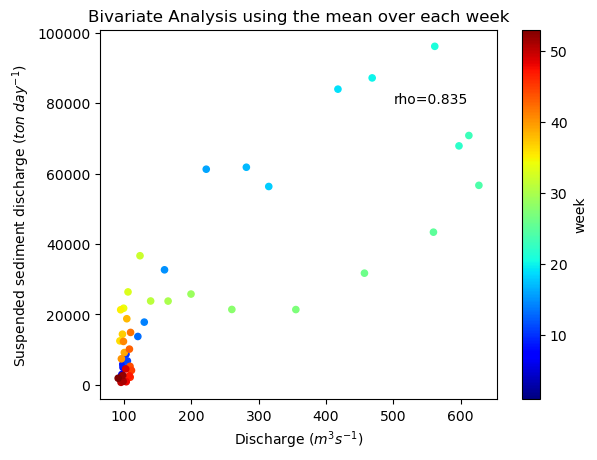

In [72]:
bivariate_plot(week_mean, 'mean', 'week')

As we can see, using the weekly mean of the values of both variables leads to a better correlation among them ($\rho=0.835$)! 

### Optional assignment

Try to think about any other possible data classification that could possibly lead to a higher (or even lower) correlation. 

Implement a function that can help you in computing the data as required (as done in *weekly_max*, for reference), and then repeat the procedure as above.
\
You can choose to work with biweekly max, monthly mean or whatever combination you can think of. Remember to compute the Pearson coefficient.    